In [1]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn import metrics

import umap

# Collecting the Data

In [2]:
def process_csv(namelist, batch_number):
    df_paths = pd.DataFrame(columns=["RESID", "LABEL1", "LABEL2", "CUTOFFS", "PATH"])
    for filename in tqdm(namelist):
        df = pd.read_csv(filename,sep=" ", header=None,names=["CUTOFF", "RESNAME", "RESID", "LABEL1", "LABEL2", "LEC"])
        resids = df.RESID.unique()
        for resid in resids:
            df_resid = df[df.RESID == resid]
            path = df_resid.LEC.values
            df_paths.loc[len(df_paths)] = [resid, df_resid.LABEL1.values[0], df_resid.LABEL2.values[0],df_resid.CUTOFF.values, path]
    # Save the result as a pickle file
    pickle_filename = f"all_paths_batch_{batch_number}.pkl"
    df_paths.to_pickle(pickle_filename)

import os.path
num_batches = 14
if not os.path.isfile(f"all_paths_batch_0.pkl"):
    import multiprocessing
    namelist = glob.glob('FIXED/*/*.label')
    print(namelist)
    # Split the namelist into num_batches equal-sized sublists
    namelist_batches = [namelist[i:i + len(namelist) // num_batches] for i in range(0, len(namelist), len(namelist) // num_batches)]
    # Process files in parallel using multiprocessing
    with multiprocessing.Pool(processes=num_batches) as pool:
        for i, namelist_batch in enumerate(namelist_batches):
            pool.apply_async(process_csv, (namelist_batch, i))
        pool.close()
        pool.join()

df_path=pd.read_pickle(f"all_paths_batch_0.pkl")
cutoffs=df_path.CUTOFFS.values
data=df_path.PATH.values

#I had to do this [:76] as some were shorter.
big_array = np.zeros((1, 76),dtype=np.float32)
big_array[0, :] = data[0][:76]

#extract data into appropriate format
labels_1=[] 
labels_2=[] 

#I had extracted the path info in batches
for j in tqdm(range(num_batches)):
    #only take the relevant rows
    df_path=pd.read_pickle(f"all_paths_batch_{j}.pkl")        
    df_path=df_path[df_path.LABEL1.values==df_path.LABEL2.values]
            
    labels_1=labels_1+list(df_path.LABEL1.values)
    labels_2=labels_2+list(df_path.LABEL1.values)
    
    data=df_path.PATH.values
    
    array_paths=np.zeros((len(data),76),dtype=np.float32)

    for i in range(len(data)):
        array_paths[i,:] = data[i][:76]

    big_array=np.concatenate([big_array, array_paths],axis=0)
    
big_array = big_array[1:]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:57<00:00,  8.39s/it]


In [3]:
mean_path=np.mean(big_array, axis=0)
norms=np.array([np.linalg.norm(mean_path-path) for path in big_array])

big_array=big_array[norms<50]
labels_1=np.array(labels_1)[norms<50]
labels_2=np.array(labels_2)[norms<50]

# Doing PCA

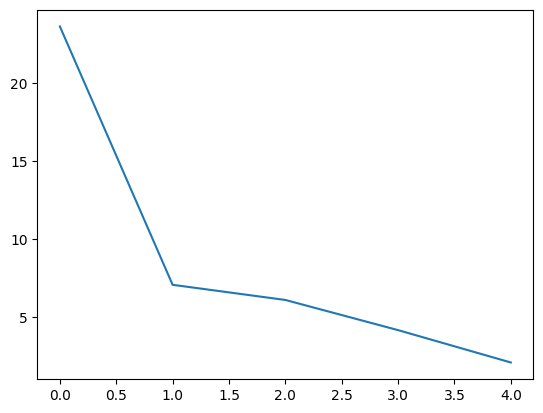

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Rescale
Sc=StandardScaler()
normed_data=Sc.fit_transform(big_array)

#Fit the PCs
Proj=PCA(n_components=5)
reduced_data=Proj.fit_transform(normed_data)

#look at the explained variance
elbo=Proj.explained_variance_
plt.plot(elbo)

# Doing the Classification

In [5]:
from sklearn.mixture import GaussianMixture
idx = np.random.randint(0, np.shape(data)[0], size=(np.shape(reduced_data)[0] // 10))
    
subset_curves=reduced_data[idx,:]
df_GMM=pd.DataFrame(columns=["predicted_labels", "true_labels", "n_clusters"])

# here we look at 4 and 6 clusters

for n in tqdm([4,6]):

    gmm = GaussianMixture(n_components=n, n_init=10)
    gmm.fit(subset_curves)

    predicted_labels = gmm.predict(reduced_data)

    df_GMM.loc[len(df_GMM)]=[predicted_labels, labels_1, n]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:27<00:00, 103.93s/it]


# Perform UMAP to Aid Visualisation

In [6]:
from umap import UMAP
#if running notebook with all the data I recommend you choose a small subset for UMAP visualisation

idx=[np.random.randint(0, np.shape(big_array)[0]) for x in range(5000)]

reducer=umap.UMAP(n_components=2)
umap_points=reducer.fit_transform(reduced_data[idx])

# Plot by the Predicted / DSSP Labels

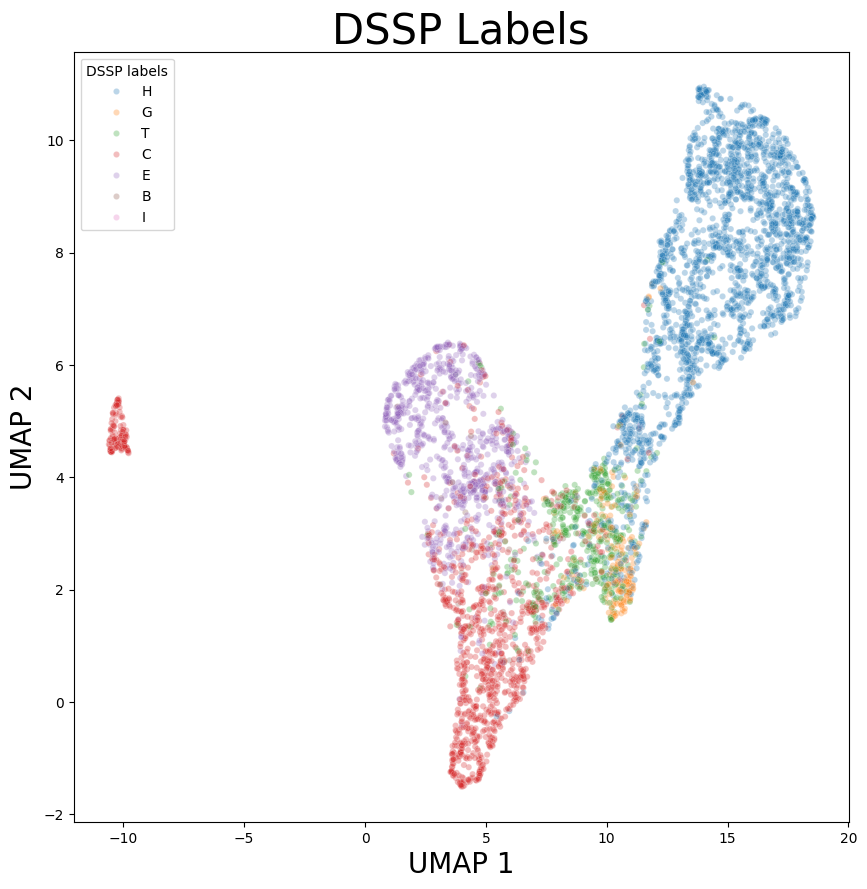

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel(f"UMAP 1",fontsize=20)
ax.set_ylabel("UMAP 2",fontsize=20)
ax.set_title("DSSP Labels",fontsize=30)

df=pd.DataFrame()
df["1"]=umap_points[:, 0]
df["2"]=umap_points[:, 1]
df["DSSP labels"]=labels_1[idx]

sns.scatterplot(df, x="1",y="2",hue="DSSP labels", 
    s=20, alpha=0.3, ax=ax)

plt.savefig(f"Consensus_LECs_Density_vs_DSSP_Labels.pdf")

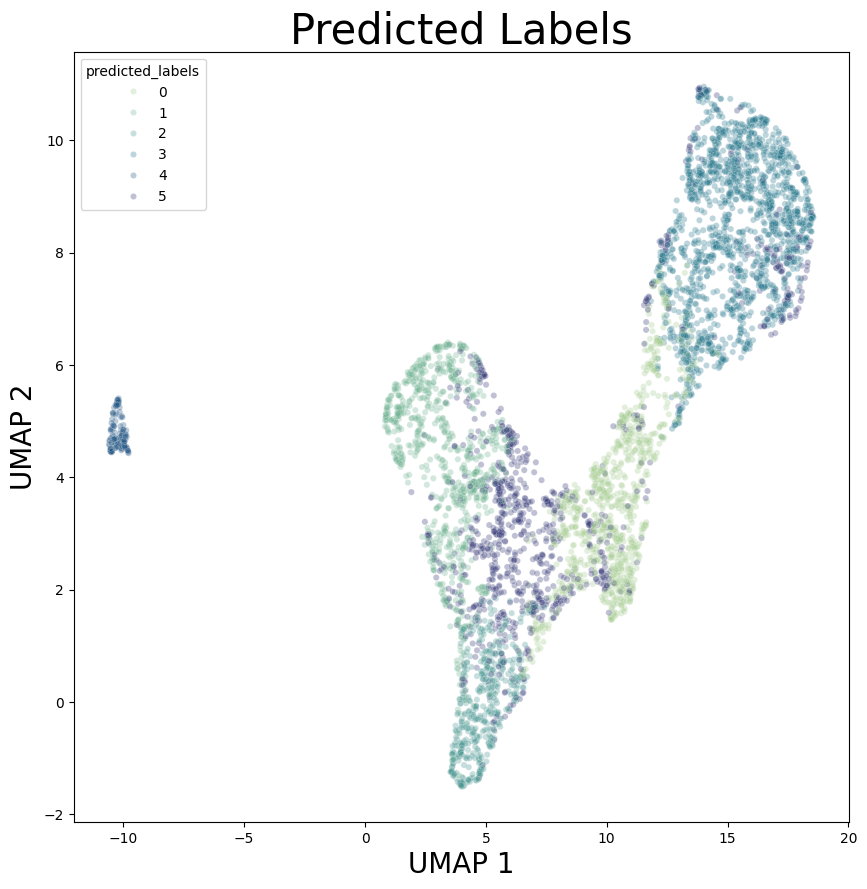

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel(f"UMAP 1",fontsize=20)
ax.set_ylabel("UMAP 2",fontsize=20)
ax.set_title("Predicted Labels",fontsize=30)

df=pd.DataFrame()
df["1"]=umap_points[:, 0]
df["2"]=umap_points[:, 1]
df["predicted_labels"]=predicted_labels[idx]

sns.scatterplot(df, x="1",y="2",hue="predicted_labels", 
    s=20, alpha=0.3, ax=ax, palette="crest")
plt.savefig(f"Consensus_LECs_Density_vs_Predicted_Labels.pdf")

# Calculating the The Density of the Points for Visualisation

In [9]:
from scipy.stats import multivariate_normal

# Calculate the density of each point using kernel density estimation (KDE)
def calculate_density(x, data, bandwidth):
    kernel = multivariate_normal(x, bandwidth)
    return kernel.pdf(data)

# Define bandwidth for KDE
bandwidth = 2

#Calculate the density for each point in the subset

densities = np.zeros(len(umap_points))
for i, point in tqdm(enumerate(umap_points)):
    densities[i] = np.mean(calculate_density(point, umap_points, bandwidth))


5000it [00:02, 2082.71it/s]


In [10]:
# Define the cmap
import matplotlib.colors as mcolors

viridis_cmap = plt.get_cmap('viridis')

positions = np.linspace(0, 1, 6) 

colors = [viridis_cmap(pos) for pos in positions]

cmap = mcolors.ListedColormap(colors)

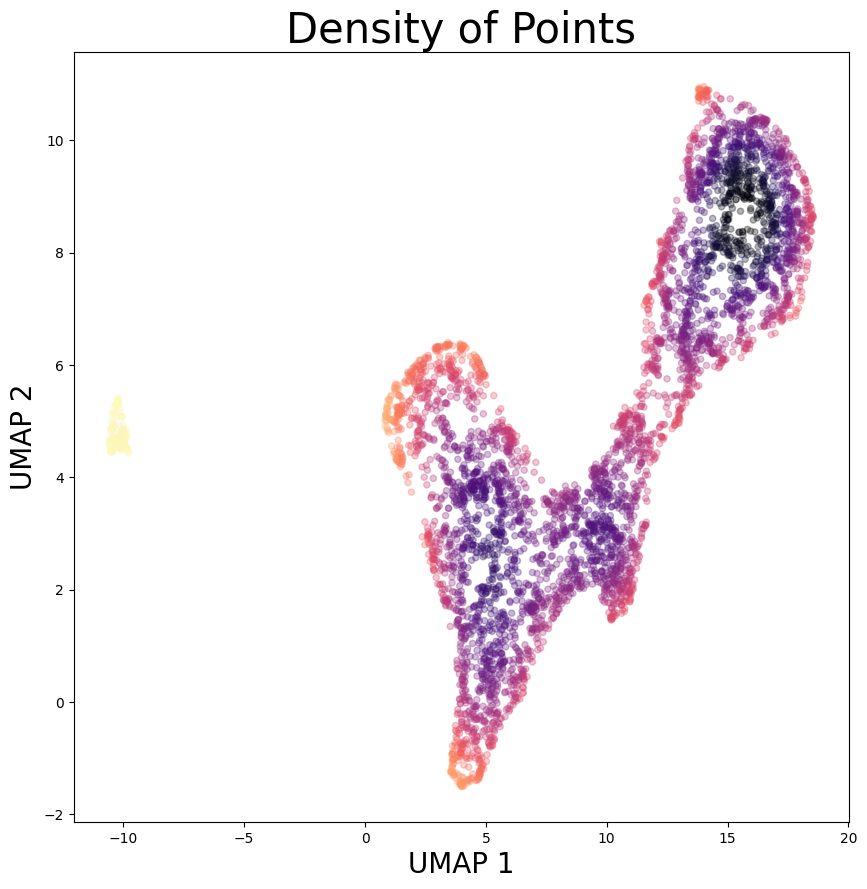

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel(f"UMAP 1",fontsize=20)
ax.set_ylabel("UMAP 2",fontsize=20)
ax.set_title("Density of Points",fontsize=30)
    
ax.scatter(umap_points[:, 0], umap_points[:, 1], c=densities, cmap="magma_r",  
    s=20, alpha=0.3)

plt.savefig(f"LECs_Density_vs_Predicted_Labels.pdf")

# Making the Heat Maps

In [12]:
#Some definitions for colour coding

u_labels=df_path.LABEL1.unique()
ord_u_labels=np.array([ord(x) for x in u_labels])

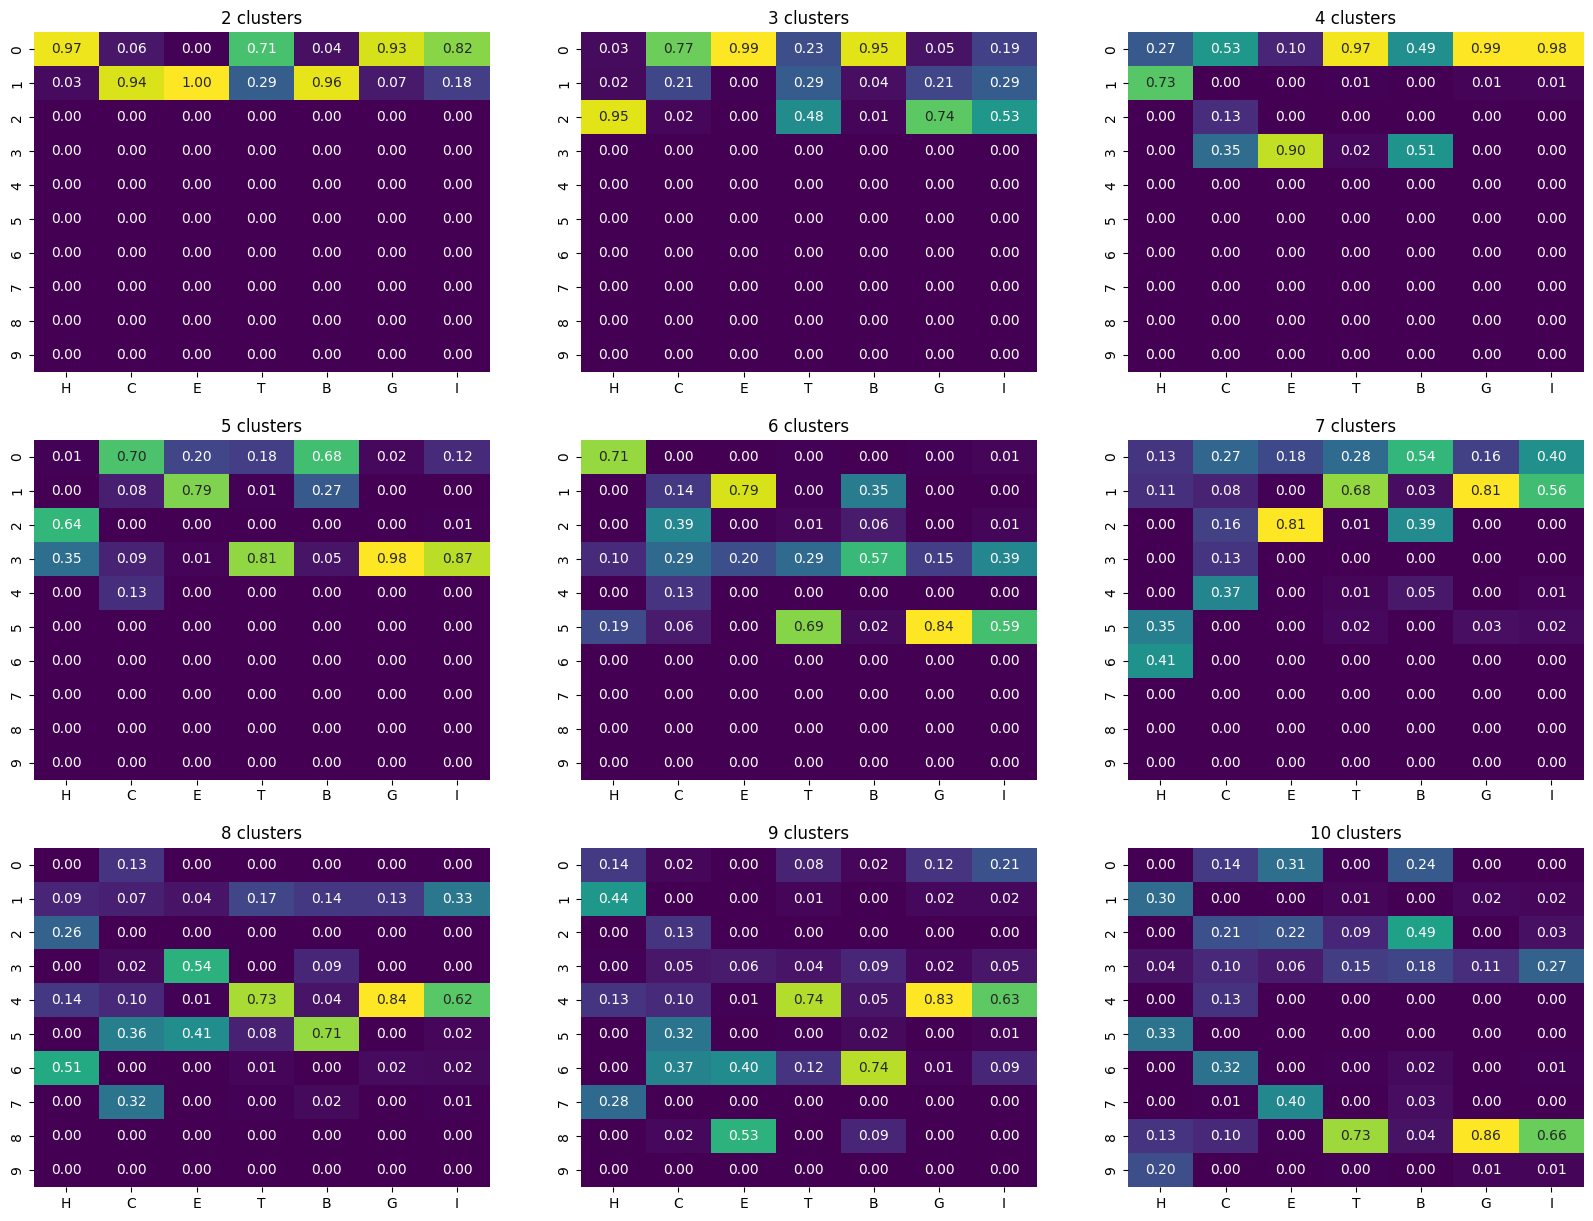

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for i, ax in enumerate(axes.flat):
    
    #fit a GMM with n_components
    gmm = GaussianMixture(n_components=i+2, n_init=10)
    gmm.fit(subset_curves)

    predicted_labels = gmm.predict(reduced_data)
    
    #store info in data frame

    df_prediction=pd.DataFrame()

    df_prediction["true_labels"]=[ord(x) for x in labels_1]
    df_prediction["normed_true_labels"]=df_prediction["true_labels"].apply(lambda y: 
                                                            np.where([x==y for x in ord_u_labels])[0][0])
    df_prediction["predicted_labels"]=predicted_labels

    A=df_prediction.groupby(["normed_true_labels",'predicted_labels'])['true_labels'].count()
    B=pd.DataFrame(A)

    HM=np.zeros([10,7])
    for index in B.index:
        HM[index[1],index[0]]=B.loc[index].true_labels
    for j in range(7):
        HM[:,j]=HM[:,j]/np.sum(HM[:,j])

    sns.heatmap(data=HM, xticklabels=u_labels, cmap='viridis', cbar=False, ax=ax,   annot=True, fmt=".2f")
    ax.set_title(f'{i + 2} clusters')

# Plotting the Curves By Predicted Labels

In [14]:
#Had to put the data in longform again to plot it.

path_long=[]
pred_long=[]
cutoffs_long=[]
labels_long=[]

idx=[np.random.randint(0, np.shape(big_array)[0]) for x in range(5000)]

all_labels=labels_1
all_pred=df_GMM[df_GMM.n_clusters==6].predicted_labels.values[0]

cutoff=cutoffs[0][:-1]

for i in tqdm(idx):
    path=big_array[i,:]
    path_long=np.concatenate((path_long,path))
    cutoffs_long=np.concatenate((cutoffs_long,cutoff))
    pred_long=pred_long+[all_pred[i] for j in range(len(path))]
    labels_long=labels_long+[all_labels[i] for j in range(len(path))]
    
df=pd.DataFrame()
df["path"]=path_long
df["cutoffs"]=cutoffs_long[:len(path_long)]
df["predictions"]=pred_long[:len(path_long)]
df["label"]=labels_long[:len(path_long)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.65it/s]


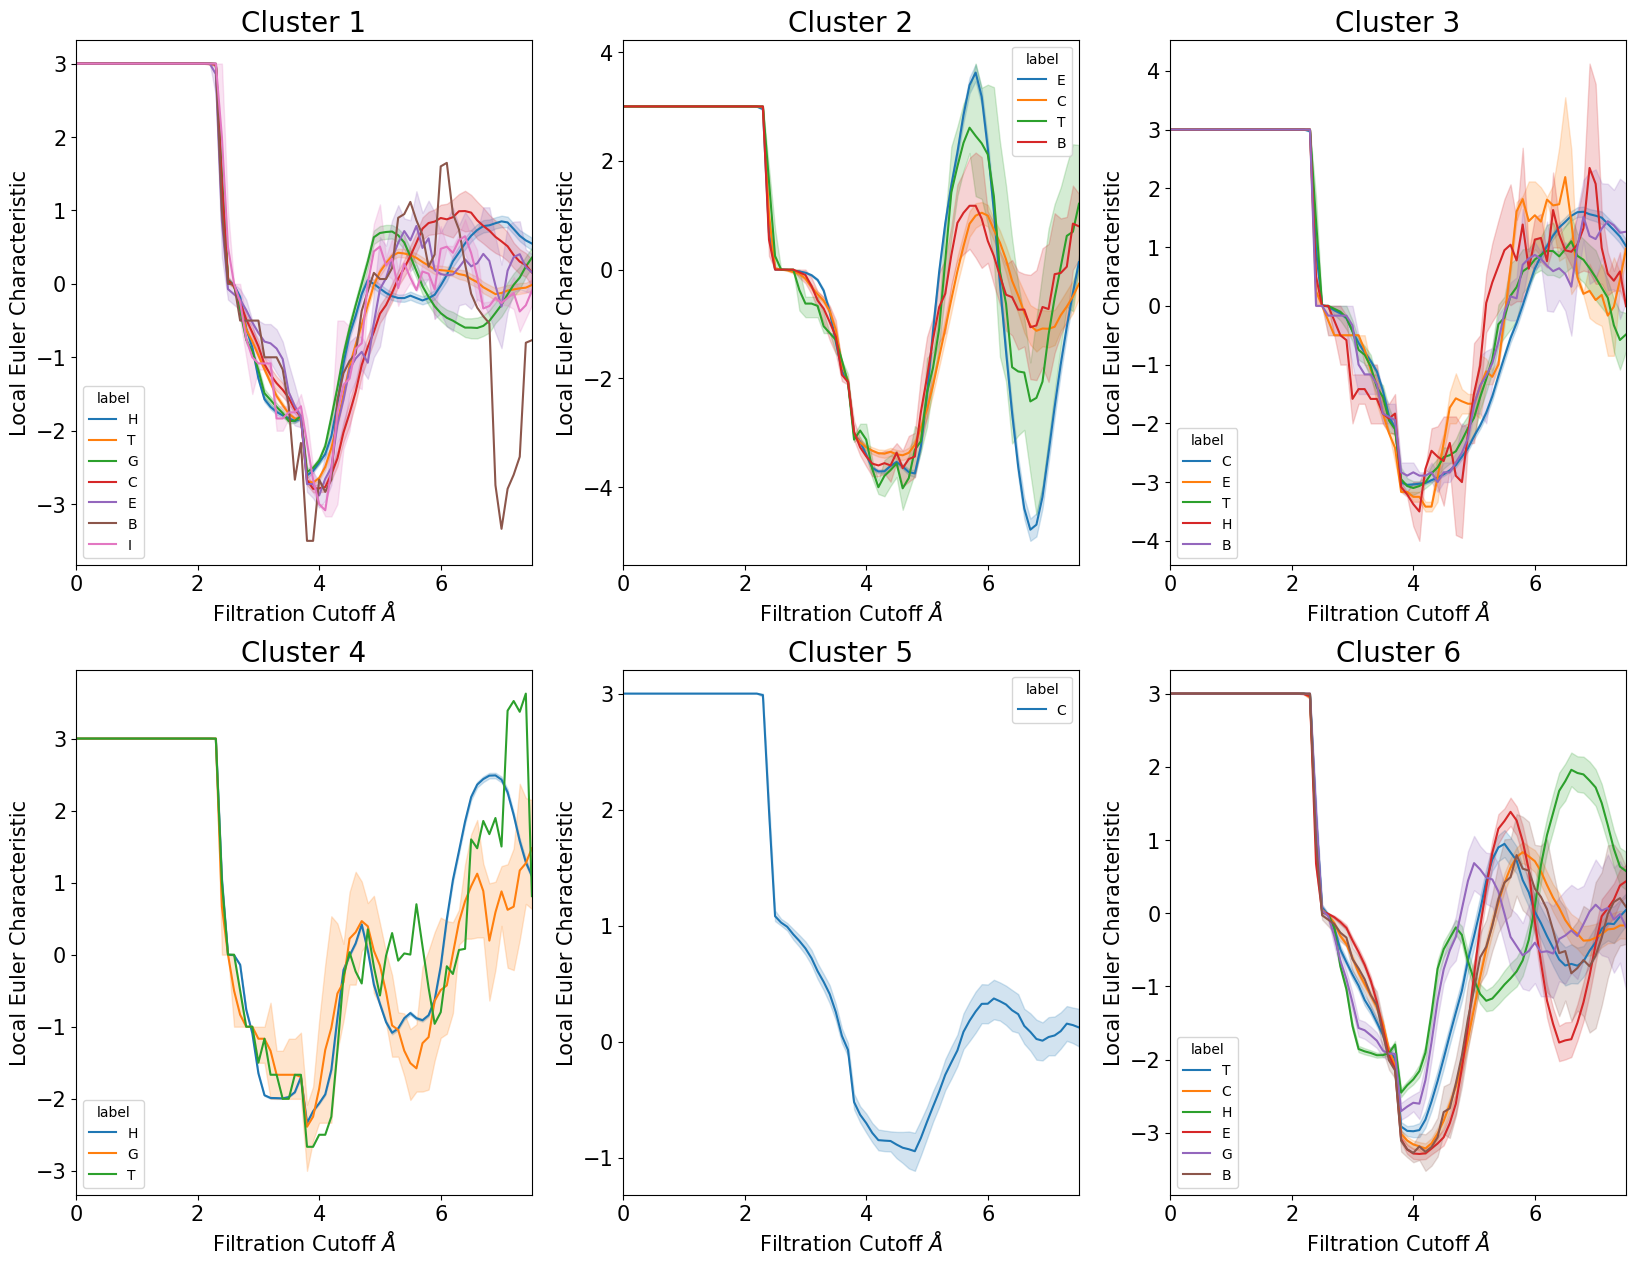

In [15]:
fig, axes = plt.subplots(2,3,figsize = (20,15))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for i, ax in enumerate(axes.flat):
    mini_df=df[df.predictions==i]
    sns.lineplot(mini_df, x="cutoffs", y="path", hue="label", ax=ax)
    ax.set_xlabel("Filtration Cutoff $\AA$", fontsize=15)
    ax.set_ylabel("Local Euler Characteristic", fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([0,7.5])
    ax.set_title(f"Cluster {i+1}",fontsize=20)

plt.savefig("LEC_paths_6_clusters.pdf")